In [1]:
import os
import random
from datetime import datetime
import pyodbc

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from scipy import sparse
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from surprise.model_selection import GridSearchCV
from surprise import SVD, BaselineOnly, Dataset, KNNBaseline, Reader, SVDpp

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Conexión a base de datos
conn = pyodbc.connect(DRIVER = '{ODBC Driver 17 for SQL Server}',
                      SERVER = 'med000008646',
                      DATABASE = 'BD_BI',
                      UID = 'ussifods',
                      PWD = 'sifods')

In [3]:
#Extraccion del dataset inical 
query1 = """select *  from [dbo].[TMP_ENCUESTAS]"""
df_ini = pd.read_sql_query(query1,conn)
#Cerrar la conexion
conn.close()

# Mostrar datos de las encuestas de satisfacción

In [4]:
df_ini.head()

,CURID,DES_CURSO,NOMBRE_ACTIVIDAD,TIPO_ACTIVIDAD,FEEDBACKID,USUARIO,NOMBRES,APELLIDOS,IDNUMBER,NUM_RESPUESTA,FECHA_REALIZADA,NOMBRE_PREGUNTA,ORDEN_PREGUNTA,TIPO_PREGUNTA,OPCIONES,OPCION_ELEGIDA,RESPUESTA,FECHAREPORTE
0,59,Clase invertida,Encuesta de satisfacción,feedback,131,16701635,MARIA LUCINDA,HIDROGO MEJIA,16701635,2942,2022-07-15 10:35:21,10.\tLa duración del curso para lograr el prop...,29,multichoice,1\n|2\n|3\n|4,3,3\n,2022-10-28 14:29:56
1,59,Clase invertida,Encuesta de satisfacción,feedback,131,16701635,MARIA LUCINDA,HIDROGO MEJIA,16701635,2942,2022-07-15 10:35:21,11.\tLos recursos pedagógicos empleados (video...,30,multichoice,1\n|2\n|3\n|4,3,3\n,2022-10-28 14:29:56
2,59,Clase invertida,Encuesta de satisfacción,feedback,131,16701635,MARIA LUCINDA,HIDROGO MEJIA,16701635,2942,2022-07-15 10:35:21,12.\tLas actividades prácticas y ejemplos pres...,31,multichoice,1\n|2\n|3\n|4,3,3\n,2022-10-28 14:29:56
3,59,Clase invertida,Encuesta de satisfacción,feedback,131,16701635,MARIA LUCINDA,HIDROGO MEJIA,16701635,2942,2022-07-15 10:35:21,13.\tLa evaluación del curso a partir de los c...,32,multichoice,1\n|2\n|3\n|4,3,3\n,2022-10-28 14:29:56
4,59,Clase invertida,Encuesta de satisfacción,feedback,131,16701635,MARIA LUCINDA,HIDROGO MEJIA,16701635,2942,2022-07-15 10:35:21,14.\tLos correos recibidos para culminar el cu...,34,multichoice,1\n|2\n|3\n|4,3,3\n,2022-10-28 14:29:56


In [5]:
#Numero de docentes por Cursos 
def docente_cursos(df):
    curso_doc = pd.DataFrame(df.groupby('DES_CURSO')['IDNUMBER'].nunique())
    curso_doc.reset_index(inplace=True)
    curso_doc.sort_values(by ='IDNUMBER', ascending=False,inplace=True)
    return curso_doc

In [6]:
docente_cursos(df_ini).head()

,DES_CURSO,IDNUMBER
14,Programa de metodologías STEAM - Secundaria,208
1,Clase invertida,180
0,Alfabetización Digital,125
4,Introducción a la Competencia Digital,114
15,Prácticas saludables para el uso de las tecnol...,109


In [7]:
# Comprimir opción elegida
df_ini.groupby('OPCION_ELEGIDA')['OPCION_ELEGIDA'].count()
## Reemplazamos los valores null por 3
df_ini['OPCION_ELEGIDA']=df_ini['OPCION_ELEGIDA'].fillna(3)
df_ini['OPCION_ELEGIDA']=df_ini['OPCION_ELEGIDA'].astype('int64')
print(df_ini['OPCION_ELEGIDA'].unique())

[3 4 2 1]


In [8]:
df = pd.DataFrame(df_ini.groupby(['CURID','IDNUMBER'])['OPCION_ELEGIDA'].mean())
df.reset_index(inplace=True)
df.columns = ['CURID','IDNUMBER','PUNTUACION']
df['PUNTUACION']= np.round(df['PUNTUACION'],0).astype(int)
df['IDNUMBER']= df['IDNUMBER'].astype(int)
df.head(10)

,CURID,IDNUMBER,PUNTUACION
0,55,513128,3
1,55,818787,3
2,55,1112370,3
3,55,1158716,4
4,55,1335498,3
5,55,1683986,3
6,55,1888335,3
7,55,2296820,2
8,55,2744040,3
9,55,3661335,4


**Verificar valores duplicados**

In [9]:
df.duplicated(["CURID","IDNUMBER","PUNTUACION"]).sum()

0

# Dividir datos para entrenamiento y prueba
*   train_data = 80%
*   test_data = 20%

In [10]:
split_value = int(len(df) * 0.80)
train_data = df[:split_value]
test_data = df[split_value:]
print(train_data.shape)
print(test_data.shape)

(1004, 3)
(252, 3)


# Analisis de datos
Contar los ratings

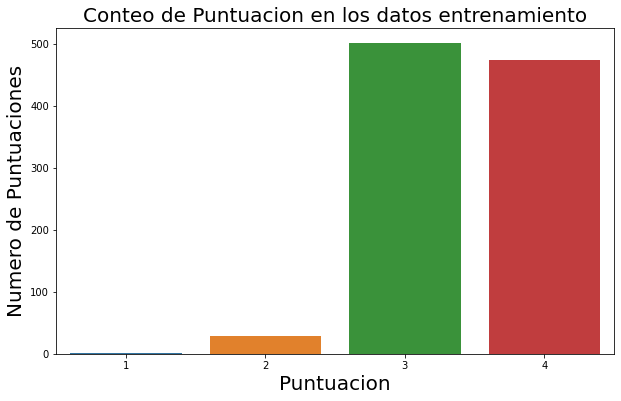

In [11]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x="PUNTUACION", data= train_data)
plt.title("Conteo de Puntuacion en los datos entrenamiento", fontsize = 20)
plt.xlabel("Puntuacion", fontsize = 20)
plt.ylabel("Numero de Puntuaciones", fontsize = 20)
plt.show()

# Crea la matrix usuario-elemento
En la matriz dispersa usuario-elemento, los valores de los elelemtos estan presentes en la columna y los valores de los usuarios están presentes en las filas. La calificación del usuario está presente en la celda

In [12]:
def get_user_item_sparse_matrix(df):
    sparse_data = sparse.csr_matrix((df.PUNTUACION, (df.IDNUMBER, df.CURID)))
    return sparse_data

**Crear matriz dispersa a partir del conjunto de datos de entrenamiento**

In [13]:
train_sparse_data = get_user_item_sparse_matrix(train_data)

In [14]:
train_sparse_data

<99999999x129 sparse matrix of type '<class 'numpy.intc'>'
	with 1004 stored elements in Compressed Sparse Row format>

**Crear la matriz dispersa a partir de datos de prueba**

In [15]:
test_sparse_data = get_user_item_sparse_matrix(test_data)

# Calificación global del curso

In [16]:
promedio_global_puntuacion = train_sparse_data.sum()/train_sparse_data.count_nonzero()
print("Promedio global puntuacion: {}".format(promedio_global_puntuacion))

Promedio global puntuacion: 3.442231075697211


**Metodo Generico para calcular la calificación promedio de la matriz dispersa**

In [17]:
def obtener_promedio_puntuacion(sparse_matrix, is_user):
    ax = 1 if is_user else 0
    sum_de_puntuacion = sparse_matrix.sum(axis=ax).A1
    no_de_puntuacion = (sparse_matrix != 0).sum(axis = ax).A1
    rows, cols = sparse_matrix.shape
    promedio_puntuacion = {i: sum_de_puntuacion[i]/no_de_puntuacion[i] for i in range(rows if is_user else cols) if no_de_puntuacion[i] != 0}
    return promedio_puntuacion

**Calcular la calificación promedio del docente**

In [18]:
promedio_puntuacion_usuario = obtener_promedio_puntuacion(train_sparse_data, True)

**Calular la calificacion promedio del curso**

In [19]:
promedio_puntuacion_curso = obtener_promedio_puntuacion(train_sparse_data, False)

# Verifique el arranque en frio para los usuarios
Aquí el 28% del total de usuarios son nuevos y no tendrán una calificacion adecuada disponible. Entonces, esto puede traer el problema del arranque en frío

In [20]:
total_users = len(np.unique(df["IDNUMBER"]))
train_users = len(promedio_puntuacion_usuario)
UsuarioNoComun = total_users - train_users
                  
print("Total no. de usuarios = {}".format(total_users))
print("No. de usuarios en la data de entrenamiento= {}".format(train_users))
print("No. de usuarios no presentes en la data de entrenamiento = {}({}%)".format(UsuarioNoComun, np.round((UsuarioNoComun/total_users)*100), 2))

Total no. de usuarios = 730
No. de usuarios en la data de entrenamiento= 523
No. de usuarios no presentes en la data de entrenamiento = 207(28.0%)


# Verifique el arranque en frio para los cursos
Aquí el 38% del total de cursos son nuevas y es posible que su calificacion no esté disponible en el conjunto de datos. Entonces esto puede traer el problema del arranque en frio

In [21]:
total_curso = len(np.unique(df["CURID"]))
train_curso = len(promedio_puntuacion_curso)
CursoNoComun = total_curso - train_curso
                  
print("Total no. de Cursos = {}".format(total_curso))
print("No. de Cursos en los datos de entrenamiento= {}".format(train_curso))
print("No. de Cursos no prensentes en los datos de entrenamiento = {}({}%)".format(CursoNoComun, np.round((CursoNoComun/total_curso)*100), 2))

Total no. de Cursos = 16
No. de Cursos en los datos de entrenamiento= 10
No. de Cursos no prensentes en los datos de entrenamiento = 6(38.0%)


# Calculo de la similitud del usuario para encontrar similitudes de los 10 usuarios principales

In [22]:
def compute_user_similarity(sparse_matrix, limit=100):
    row_index, col_index = sparse_matrix.nonzero()
    rows = np.unique(row_index)
    similar_arr = np.zeros(61700).reshape(617,100)
    
    for row in rows[:limit]:
        sim = cosine_similarity(sparse_matrix.getrow(row), train_sparse_data).ravel()
        similar_indices = sim.argsort()[-limit:]
        similar = sim[similar_indices]
        similar_arr[row] = similar
    
    return similar_arr

In [23]:
similar_user_matrix = compute_user_similarity(train_sparse_data, 100)

IndexError: index 24927 is out of bounds for axis 0 with size 617

In [ ]:
similar_user_matrix[0]

# Cargar titulos de los cursos

# Calular matriz de similitud de cursos

# Crear matriz dispersa de muestra
Este método se utilizará para generar sample sparse matrix. se generaran nuevas caracteristicas de similitud a partir de esta matriz dispersa de muestra

In [24]:
def get_sample_sparse_matrix(sparse_matrix, no_of_users, no_of_movies):
    users, movies, ratings = sparse.find(sparse_matrix)
    uniq_users = np.unique(users)
    uniq_movies = np.unique(movies)
    np.random.seed(15) 
    user = np.random.choice(uniq_users, no_of_users, replace = False)
    movie = np.random.choice(uniq_movies, no_of_movies, replace = True)
    mask = np.logical_and(np.isin(users, user), np.isin(movies, movie))
    sparse_matrix = sparse.csr_matrix((ratings[mask], (users[mask], movies[mask])), 
                                                     shape = (max(user)+1, max(movie)+1))
    return sparse_matrix

**Matriz dispersa de muestra para los datos de entrenamiento**

In [25]:
train_sample_sparse_matrix = get_sample_sparse_matrix(train_sparse_data, 100, 10)

**Matriz dispersa de muestra para los datos de prueba**

In [26]:
test_sparse_matrix_matrix = get_sample_sparse_matrix(test_sparse_data, 50, 5)

# Un método genérico para generar caracteristicas similares
Esto generará caracteristicas similares a continuación:
*   similar_user_rating1
*   similar_user_rating2
*   similar_user_rating3
*   similar_user_rating4
*   similar_user_rating5
*   similar_cur_rating1
*   similar_cur_rating2
*   similar_cur_rating3
*   similar_cur_rating4
*   similar_cur_rating5

In [28]:
def create_new_similar_features(sample_sparse_matrix):
    global_avg_rating = obtener_promedio_puntuacion(sample_sparse_matrix, False)
    global_avg_users = obtener_promedio_puntuacion(sample_sparse_matrix, True)
    global_avg_movies = obtener_promedio_puntuacion(sample_sparse_matrix, False)
    sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_sparse_matrix)
    new_features_csv_file = open("new_features.csv", mode = "w")
    
    for IDNUMBER, CURID, PUNTUACION in zip(sample_train_users, sample_train_movies, sample_train_ratings):
        similar_arr = list()
        similar_arr.append(IDNUMBER)
        similar_arr.append(CURID)
        similar_arr.append(sample_sparse_matrix.sum()/sample_sparse_matrix.count_nonzero())
        
        similar_users = cosine_similarity(sample_sparse_matrix[IDNUMBER], sample_sparse_matrix).ravel()
        indices = np.argsort(-similar_users)[1:]
        ratings = sample_sparse_matrix[indices, CURID].toarray().ravel()
        top_similar_user_ratings = list(ratings[ratings != 0][:5])
        top_similar_user_ratings.extend([global_avg_rating[CURID]] * (5 - len(ratings)))
        similar_arr.extend(top_similar_user_ratings)
        
        similar_movies = cosine_similarity(sample_sparse_matrix[:,CURID].T, sample_sparse_matrix.T).ravel()
        similar_movies_indices = np.argsort(-similar_movies)[1:]
        similar_movies_ratings = sample_sparse_matrix[IDNUMBER, similar_movies_indices].toarray().ravel()
        top_similar_movie_ratings = list(similar_movies_ratings[similar_movies_ratings != 0][:5])
        top_similar_movie_ratings.extend([global_avg_users[IDNUMBER]] * (5-len(top_similar_movie_ratings)))
        similar_arr.extend(top_similar_movie_ratings)
        
        similar_arr.append(global_avg_users[IDNUMBER])
        similar_arr.append(global_avg_movies[CURID])
        similar_arr.append(PUNTUACION)
        
        new_features_csv_file.write(",".join(map(str, similar_arr)))
        new_features_csv_file.write("\n")
        
    new_features_csv_file.close()
    new_features_df = pd.read_csv('new_features.csv', names = ["idnumber", "curid", "total_average", "similar_user_pun1", 
                                                               "similar_user_pun2", "similar_user_pun3", 
                                                               "similar_user_pun4", "similar_user_pun5", 
                                                               "similar_cur_rating1", "similar_cur_rating2", 
                                                               "similar_cur_rating3", "similar_cur_rating4", 
                                                               "similar_cur_rating5", "user_average", 
                                                               "cur_average", "puntuacion"])
    return new_features_df

# Genere caracteristicas similares para los datos de entrenamiento

In [29]:
train_new_similar_features = create_new_similar_features(train_sample_sparse_matrix)

In [30]:
train_new_similar_features = train_new_similar_features.fillna(0)
train_new_similar_features.head()

,idnumber,curid,total_average,similar_user_pun1,similar_user_pun2,similar_user_pun3,similar_user_pun4,similar_user_pun5,similar_cur_rating1,similar_cur_rating2,similar_cur_rating3,similar_cur_rating4,similar_cur_rating5,user_average,cur_average,puntuacion
0,1335498,55,3.409091,4,3.0,4.0,3.0,3.0,4.0,3.0,4.000000,3.500000,3.500000,3.500000,3.333333,3.0
1,2744040,55,3.409091,3,3.0,4.0,3.0,4.0,3.0,3.0,3.000000,3.000000,3.000000,3.000000,3.333333,3.0
2,8655926,55,3.409091,3,4.0,4.0,3.0,4.0,3.0,3.0,3.000000,3.000000,3.000000,3.000000,3.333333,3.0
3,19238990,55,3.409091,4,3.0,3.0,3.0,4.0,4.0,4.0,4.000000,4.000000,4.000000,4.000000,3.333333,4.0
4,20430547,55,3.409091,3,3.0,3.0,3.0,3.0,4.0,3.0,3.666667,3.666667,3.666667,3.666667,3.333333,4.0


# Genere características similares para los datos de prueba

In [31]:
test_new_similar_features = create_new_similar_features(test_sparse_matrix_matrix)

In [32]:
test_new_similar_features = test_new_similar_features.fillna(0)
test_new_similar_features.head()

,idnumber,curid,total_average,similar_user_pun1,similar_user_pun2,similar_user_pun3,similar_user_pun4,similar_user_pun5,similar_cur_rating1,similar_cur_rating2,similar_cur_rating3,similar_cur_rating4,similar_cur_rating5,user_average,cur_average,puntuacion
0,46447280,128,3.178571,3,3,3,3.0,3.0,3.0,3.0,3.0,3.0,3.25,3.0,0.0,0.0
1,47637992,128,3.178571,3,3,3,3.0,3.0,3.0,3.0,3.0,3.0,3.25,3.0,0.0,0.0
2,72008454,128,3.178571,3,3,3,3.0,3.0,3.0,3.0,3.0,3.0,3.25,3.0,0.0,0.0
3,80209750,128,3.178571,3,3,3,4.0,4.0,4.0,4.0,4.0,4.0,3.25,4.0,0.0,0.0
4,7258663,583,3.178571,3,3,3,3.0,3.0,3.0,3.0,3.0,3.0,3.00,3.0,0.0,0.0


# Construcción del modelo de aprendizaje 

In [33]:
x_train = train_new_similar_features.drop(["idnumber", "curid", "puntuacion"], axis = 1)

x_test = test_new_similar_features.drop(["idnumber", "curid", "puntuacion"], axis = 1)

y_train = train_new_similar_features["puntuacion"]

y_test = test_new_similar_features["puntuacion"]

In [34]:
def error_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

In [35]:
clf = xgb.XGBRegressor(n_estimators = 100, silent = False, n_jobs  = 10)
clf.fit(x_train, y_train)

[10:59:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=10, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [36]:
y_pred_test = clf.predict(x_test)

In [37]:
rmse_test = error_metrics(y_test, y_pred_test)
print("RMSE = {}".format(rmse_test))

RMSE = 0.10843608103760381


# Importancia de las caracteristicas
La importancia de las caracterisiticas es una técnica importante que selecciona una puntuación para ingresar caracteristicas en función de su valor para predecir una variable de destino

In [38]:
def plot_importance(model, clf):
    fig = plt.figure(figsize = (8, 6))
    ax = fig.add_axes([0,0,1,1])
    model.plot_importance(clf, ax = ax, height = 0.3)
    plt.xlabel("F Score", fontsize = 20)
    plt.ylabel("Features", fontsize = 20)
    plt.title("Feature Importance", fontsize = 20)
    plt.tick_params(labelsize = 15)
    
    plt.show()

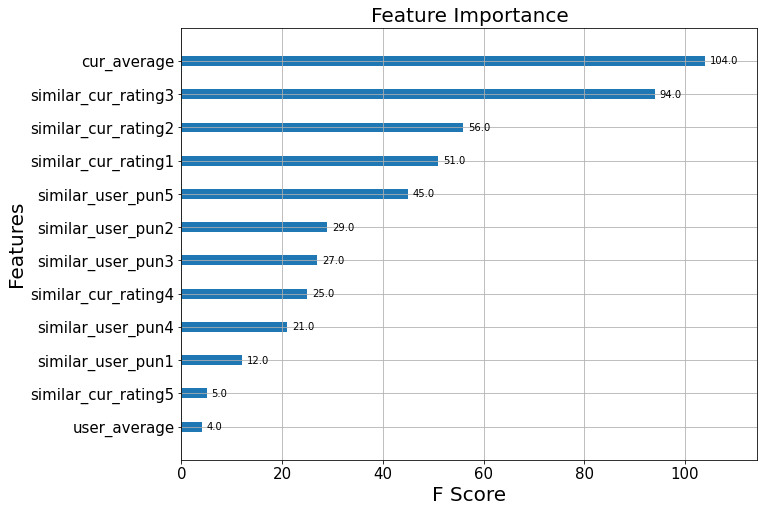

In [39]:
plot_importance(xgb, clf)